#### FIRST_NAME = "Claude"
#### LAST_NAME = "Kouakou"
#### STUDENT_ID = "801438848"

# Data Descrption - Objectives

# Unstructured Medical Text Dataset
 We are trying to design assistive technology that can identify, with high precision, the class of problems described in the abstract. In the given dataset, abstracts from 5 different conditions have been included: 
##### 1 - digestive system diseases, 
##### 2 - cardiovascular diseases, 
##### 3 - neoplasms, 
##### 4 - nervous system diseases, 
##### 5 - and general pathological conditions.
The training dataset consists of 14438 records and the test dataset consists of 14442 records. The train data has classes whereas, the test data classes are needed to be predicted.
The data are provided as text in train.dat and test.dat, which should be processed appropriately.

## Structured Heart Disease Dataset 
This data set dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V. All published experiments refer to using a subset of 14 attrinbutes. The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease.
##### 1 age
##### 2 sex
##### 4 chest pain type (4 values)
##### 5 resting blood pressure
##### 6 serum cholestoral in mg/dl
##### 7 fasting blood sugar > 120 mg/dl
##### 8 resting electrocardiographic results (values 0,1,2)
##### 9 maximum heart rate achieved
##### 10 exercise induced angina
##### 11 oldpeak = ST depression induced by exercise relative to rest
##### 12 the slope of the peak exercise ST segment
##### 13 number of major vessels (0-3) colored by flourosopy
##### 14 thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

### Load the appropiate imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pdb import set_trace
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D, Input, Concatenate, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib

# Set dataset path
Path = "C:/Users/cnkou/OneDrive/Documents/Education/UNCC/ITCS 5154/_Projects/Predictive Health Risk Models/Unstructured Text/Lab/data/"
# Patient conditions from the unstructured dataset 
conditions = [
"digestive system diseases", 
"cardiovascular diseases", 
"neoplasms", 
"nervous system diseases", 
"general pathological conditions"
]

----------------------------------------------------------------------------
 Load and preprocess structured data (heart.csv)
----------------------------------------------------------------------------

In [2]:
features = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca" ,"thal", "target"]

heart_df = pd.read_csv(Path + "heart.csv")
heart_df = resample(heart_df, replace=True, n_samples=30000, random_state=42)
heart_df = pd.DataFrame(heart_df, columns = features)  # Convert NumPy array to DataFrame

X_heart = heart_df.drop(columns=["target"]).values
 
y_heart = heart_df["target"].values
y_heart_df = pd.DataFrame(y_heart, columns = ['target']) 

heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
860,52,1,0,112,230,0,1,160,0,0.0,2,1,2,0
121,44,1,0,120,169,0,1,144,1,2.8,0,0,1,0
466,44,1,1,130,219,0,0,188,0,0.0,2,0,2,1
330,37,0,2,120,215,0,1,170,0,0.0,2,0,2,1
87,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0


In [3]:
uniques, counts = np.unique(y_heart, return_counts=True)

print(f"Unique values in t_test: {uniques}")
print(f"Number of times each unqiue value appears in t_test: {counts}")

Unique values in t_test: [0 1]
Number of times each unqiue value appears in t_test: [14500 15500]


In [4]:
rows_with_null = y_heart[heart_df.isnull().any(axis=1)]
rows_with_null

array([], dtype=int64)

In [5]:
# Standardize structured data
scaler = StandardScaler()
X_heart = scaler.fit_transform(X_heart)

# Load and preprocess unstructured text data (train.dat)

In [6]:
train_data = pd.read_csv(Path + "train.dat", sep="\t", header=None)
train_data.rename(columns = {0: 'conditions', 1: 'full_text'}, inplace=True)
train_data = train_data[train_data['conditions'] != 5]# Drop label '5' from dataset 
train_data = resample(train_data, replace=True, n_samples=X_heart.shape[0], random_state=42)
train_data.reset_index(drop=True, inplace=True)

labels = train_data['conditions'].values  # Extract labels
labels -= 1 # Convert from {1,2,3,4} to {0,1,2,3}
texts = train_data['full_text'].astype(str).values  # Convert text column to string

### Add a count plot of the conditions that provide some sort of insight into the data set.

In [23]:
luniques, lcounts = np.unique(labels, return_counts=True)

print(f"Unique values in labels: {luniques}")
print(f"Number of times each unique value appears in labels: {lcounts}")

Unique values in t_test: [0 1 2 3]
Number of times each unqiue value appears in t_test: [9821 4679 6076 9424]


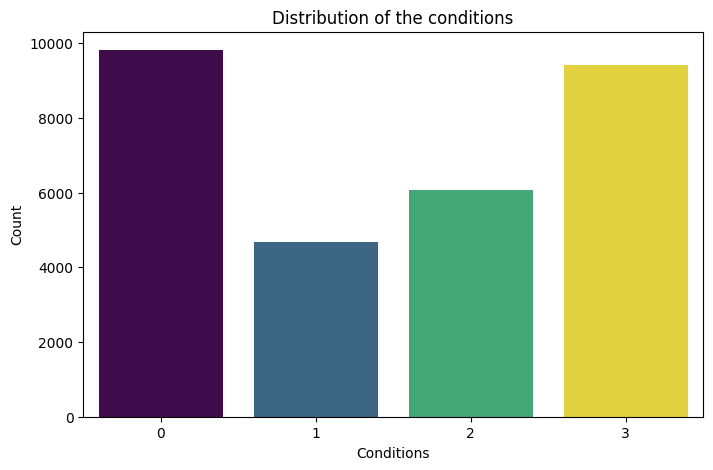

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x="conditions", data=train_data, hue="conditions", palette="viridis", legend=False)
plt.title("Distribution of the conditions")
plt.xlabel("Conditions")
plt.ylabel("Count")
plt.show()

# Load and Preprocess Unstructured Medical Test Data (text) for Prediction

In [8]:
df_test = pd.read_csv(Path +'test.dat', sep='\t', header=None)
print("df_test Shape: ", (df_test.shape))

df_test.rename(columns = {0: 'full_text'}, inplace=True)
df_test.info()
print(df_test.head())

df_test Shape:  (14442, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442 entries, 0 to 14441
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  14442 non-null  object
dtypes: object(1)
memory usage: 113.0+ KB
                                           full_text
0  Excision of limbal dermoids. We reviewed the c...
1  Bell's palsy. A diagnosis of exclusion. In cas...
2  Retained endobronchial foreign body removal fa...
3  Recurrent buccal space abscesses: a complicati...
4  Intracranial fibromatosis. Fibromatoses are un...


# Tokenization and Padding**

In [27]:
max_words = 20000  # Vocabulary size
max_len = 100  # Max length of each text sequence

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X_text = tokenizer.texts_to_sequences(texts)
X_text = pad_sequences(X_text, maxlen=max_len, padding="post")

# One-hot encode structured data

In [10]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_heart_encoded = encoder.fit_transform(X_heart)

# Convert labels to categorical (4 classes)

In [11]:
num_classes = 4
y_categorical = to_categorical(labels, num_classes=num_classes)

#  Create the text_model: Text Model (Unstructured Data)

In [12]:
text_input = Input(shape=(max_len,), name="text_input")  # Input for text data
text_model = Sequential([
    Embedding(max_words, 128),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(128, activation="relu"),
    Dropout(0.3)
])
text_output = text_model(text_input)  # Call model with input layer


#  Create the structured_model: Structured Model (Structured Data)

In [13]:
structured_input = Input(shape=(X_heart_encoded.shape[1],), name="structured_input")  # Input for structured data
structured_model = Sequential([
    Input(shape=(X_heart_encoded.shape[1],)),
    Dense(64, activation="relu" ),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(16, activation="relu"),
    Dropout(0.3),
    Dense(8, activation="relu")
])
structured_output = structured_model(structured_input)  # Call model with input layer


# Create the Fusion Layer (merged): Combine Both Models: text_model and structured_model

In [14]:
merged = Concatenate()([text_model.output, structured_model.output])
merged = Dense(128, activation="relu")(merged)
merged = Dropout(0.3)(merged)
merged = Dense(64, activation="relu")(merged)
output = Dense(num_classes, activation="softmax")(merged)

#  Create the Final Model (final_model) 

In [15]:
final_model = Model(inputs=[text_model.input, structured_model.input], outputs=output)
final_model.compile(optimizer=Adam(learning_rate=0.0002), loss="categorical_crossentropy", metrics=["accuracy"])


# Model Summary

In [16]:
final_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ structured_input (InputLayer) │ (None, 398)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 128)               │       2,675,328 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_1 (Sequential)     │ (None, 8)                 │          28,280 │ structured_input[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 136)               │               0 │ sequential[0][0],          │
│                               │                           │                 │ sequential_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 128)               │          17,536 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 128)               │               0 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 64)                │           8,256 │ dropout_4[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 4)                 │             260 │ dense_6[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,729,660 (10.41 MB)

 Trainable params: 2,729,660 (10.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train the whole Model

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = final_model.fit([X_text, X_heart_encoded], y_categorical, epochs=20, batch_size=32, validation_split=0.2, callbacks = [early_stop] )

print("---------------- Tranning Complete----------------------------")

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - accuracy: 0.4272 - loss: 1.2096 - val_accuracy: 0.7927 - val_loss: 0.6428
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.8381 - loss: 0.5086 - val_accuracy: 0.8855 - val_loss: 0.3646
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.9116 - loss: 0.2864 - val_accuracy: 0.8995 - val_loss: 0.3029
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - accuracy: 0.9281 - loss: 0.2190 - val_accuracy: 0.9065 - val_loss: 0.2842
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.9273 - loss: 0.1887 - val_accuracy: 0.9093 - val_loss: 0.2542
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.9294 - loss: 0.1656 - val_accuracy: 0.9062 - val_loss: 0.2543
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 43s 57ms/step - accuracy: 0.9346 - loss: 0.1455 - val_accuracy: 0.9052 - val_loss: 0.2540
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 45s 60ms/step - accuracy: 0.9326 - loss: 0.1361 - 

# Evaluate Model

In [18]:
loss, accuracy = final_model.evaluate([X_text, X_heart_encoded], y_categorical)
print(f"Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")


938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9410 - loss: 0.1221
Test Accuracy: 0.9333, Test Loss: 0.1470


# Make Predictions

In [19]:
def predict(model, text, heart_rec):
    X_test_seq = tokenizer.texts_to_sequences(text)
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
    # Convert to NumPy array for TensorFlow
    X_test_padded = np.array(X_test_padded).astype(np.float32)
    y_pred_probs = model.predict([X_test_padded, heart_rec])

    return y_pred_probs
# get some data for prediction
X_test = df_test[:1]
X_heart_test = X_heart_encoded[:1]

y_pred = predict(final_model, X_test, X_heart_test )

#  Convert probabilities to class labels (highest probability wins)
y_Class_pred = np.argmax(y_pred, axis=1)

print(f"Predicted condition of the patient: {y_Class_pred[0]}-", conditions[y_Class_pred[0]])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
Predicted condition of the patient: 2- neoplasms


# Plot the learning curve of the training

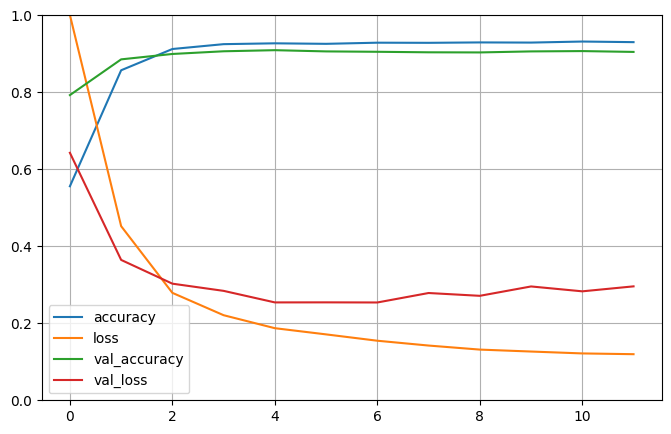

In [20]:
pd.DataFrame(history.history).plot(figsize= (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

# Plot the confusion matrix & F1-score

938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step


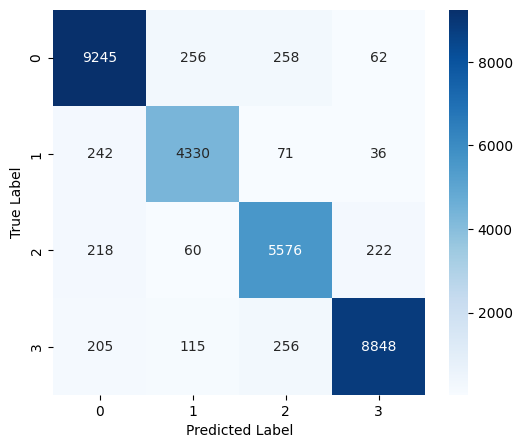

Classification Report:
              precision    recall  f1-score   support

           0     0.9329    0.9414    0.9371      9821
           1     0.9095    0.9254    0.9174      4679
           2     0.9050    0.9177    0.9113      6076
           3     0.9651    0.9389    0.9518      9424

    accuracy                         0.9333     30000
   macro avg     0.9281    0.9308    0.9294     30000
weighted avg     0.9337    0.9333    0.9334     30000



In [21]:
# Predict
y_pred = final_model.predict([X_text, X_heart_encoded])
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_categorical, axis=1) 

conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Step 4: Display Confusion Matrix as a Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))

# Interpretation:
Per-Class Metrics (Rows 0, 1, 2, 3)
* Each row represents a class label (0, 1, 2, 3), and the columns show performance metrics for that class.

   * Precision – Out of all predictions for this class, how many were correct?

   * Example: Class 0 (0.9426 precision) → 94.26% of samples predicted as class 0 were actually class 0.
* Recall (Sensitivity) – Out of all actual occurrences of this class, how many were correctly identified?

   * Example: Class 1 (0.9312 recall) → 93.12% of actual class 1 samples were correctly predicted.
* F1-score – The harmonic mean of precision & recall, balancing false positives and false negatives.

   * Example: Class 2 (0.8997 F1-score) → A good balance of precision & recall.
* Support – The number of true instances of each class in the dataset.

   * Example: Class 3 has 9424 instances in the test set.
# Overall:
#### Overall Metrics (Last 3 Rows)
* Accuracy (0.9311 or 93.11%) – The percentage of correctly classified samples across all classes.

   * The model correctly classified 93.11% of the 30,000 samples.
* Macro Average (0.9244 precision, 0.9284 recall, 0.9263 F1-score)

   * A simple average across all classes.
   * Treats all classes equally, useful if your dataset is imbalanced.
* Weighted Average (0.9314 precision, 0.9311 recall, 0.9312 F1-score)

   * Takes class imbalance into account, giving more weight to classes with more instances.

Strong overall performance (93.11% accuracy, high F1-scores for all classes).
* Class 1 has slightly lower precision (0.8989), meaning more false positives.
* Class 2 has the lowest F1-score (0.8997), but still quite balanced.
* Model is well-balanced across all classes, with no major class struggling.


# Save the Model & the Encoder

In [22]:
model_file = Path + '5154_Claude_Project_model.keras'
# Save the fitted encoder
joblib.dump(encoder, Path + "5154_Claude_Project_onehot_encoder.pkl")
# Save the final model
final_model.save( model_file)